In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import HalfspaceIntersection, ConvexHull

# 4. Computing Solution Concepts of Normal-form games

This chapter deals with the algorithms to compute things like equilibria, domination, etc. It starts with the easiest one, which is the zero-sum game:

## 4.1 Computing Nash equilibria of two-player, zero-sum games

In the previous chapter the idea of a minmax and maxmin solution was introduced. In a zero sum 2-player game it was noted that at equilibrium each player receives their minmax / maxmin value. We can use this to calculate the equilibrium by linear programming. 

Minmax means that the agent makes their best decision, given the other player will then minimise their return. Say I am player 1 and my best action is $A_1^j$. Then player 2 minimises my return by finding a mixed strategy $s_2$, to minimise:

$$\sum_{k} U_1(A_1^j,A_2^k)s_2^k$$

Where $U_1$ is player 1's utility function and $k$ is the index of each action player 2 could take.

This can be re-written as a linear-programming problem:

$$
\begin{align*}
\text{minimise} \quad & v_1 \\
\text{subject to} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k \leq v_1 \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\end{align*}
$$

(Why? Well, $\min f(x)$ is the same as $\min y$ subject to $f(x)\leq y$.

Of course, we don't actually know which action $j$ is the best for player 1, so we need to check every one:

$$
\begin{align*}
\text{minimise} \quad & v_1 \\
\text{subject to} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k \leq v_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\end{align*}
$$

Consider the Matching Pennies problem again:

$
\begin{array}{c|cc}
\text{} & \text{H} & \text{T} \\
\hline
\text{H} & 1,-1 & -1,1 \\
\text{T} & -1,1 & 1,-1 \\
\end{array}
$

Written using the above strategy for player 1 this gives (here $s_2^1$ being the chance of player 2 going heads, $s_2^2$ their chance of tails):

$$
\begin{align*}
\text{minimise} \quad & v_1 \\
\text{subject to} \quad & s_2^1 - s_2^2 \leq v_1 \quad \text{(player 1 goes heads)} \\
\text{} \quad & -s_2^1+s_2^2 \leq v_1 \quad \text{(player 1 goes tails)} \\
\text{} \quad & s_2^1 + s_2^2=1 \\
\text{} \quad & s_2 \geq 0 \\
\end{align*}
$$

The answer here is that $s_2^1=s_2^2=\frac{1}{2}$. 

Here is an example for the more complicated game paper/scissors/rock. Note that scipy does $\min c\cdot x$, subject to $A\cdot x \geq b$, so the signs are flipped here in the function call.

In [2]:
c = np.array([0,0,0,1])
coefA_ub = np.array([
    [0,-1,1,-1], # PAPER. If player 2 now goes paper player 1 gets 0, -1 if scissors, 1 if rock.
    [1,0,-1,-1], # SCISSORS. Note, as above the -1 at the end is because a+b+c<d is turned into a+b+c-d<0
    [-1,1,0,-1], # ROCK.
])
coefb_ub = np.array([0,0,0])
coefA_eq = np.array([[1,1,1,0]])
coefb_eq = np.array([1])
res = linprog(c, A_ub=-coefA_ub, b_ub=-coefb_ub, A_eq=coefA_eq, b_eq=coefb_eq)
print("Player 2 strategy at equilibrium:",res["x"].round(2)[:3])
print("Player 1 utility:",res["x"].round(2)[-1])

Player 2 strategy at equilibrium: [0.33 0.33 0.33]
Player 1 utility: 0.0


There we go. Unsuprisingly, the utility is 0 and the best option is to be random. 

We can also work out the strategy for player 1. One option is to do the above again in reverse. Another is to do maxmin instead, which corresponds to the dual problem:

$$
\begin{align*}
\text{maximise} \quad & v_1 \\
\text{subject to} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_1^j \leq v_1 \quad \forall A_2^k \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_1^j\geq 0 \\
\end{align*}
$$

As a final note it can be useful to reformulate the equations from before (or the ones right above) by adding slack variables and turning the inequalities into equalities:

$$
\begin{align*}
\text{minimise} \quad & v_1 \\
\text{subject to} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k + r_1^j = v_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & r_1^j\geq 0 \\
\end{align*}
$$

### 4.1.1 Note on 2-action games

While the next section will show it is complicated to calculate equilibria in general two-player games, it is thankfully somewhat simpler if there are only two actions each.

Consider the table:

$
\begin{array}{c|cc}
\text{} & \text{A} & \text{B} \\
\hline
\text{A} & x_{11},y_{11} & x_{12},y_{12} \\
\text{B} & x_{21},y_{21} & x_{22},y_{22} \\
\end{array}
$

Say the probability of $A$ is $s_1$ and $s_2$ respectively. Then the benefit player 1 expects is:

$$x_{11}s_1s_2+x_{12}s_1(1-s_2)+x_{21}(1-s_1)s_2+x_{22}(1-s_1)(1-s_2)$$

Which can be expanded as:

$$x_{11}s_1s_2+x_{12}s_1-x_{12}s_1s_2+x_{21}s_2-x_{21}s_1s_2+x_{22}-x_{22}s_2-x_{22}s_1+x_{22}s_1s_2$$

Collecting the $s_1$ term:

$$s_1(x_{11}s_2+x_{12}-x_{12}s_2-x_{21}s_2-x_{22}+x_{22}s_2)+x_{21}s_2+x_{22}-x_{22}s_2$$

If this game has a mixed strategy solution for player 1 we need player 1 to be indifferent between their actions given what player 2 does, which means we need to set the contents of the bracket above to 0:

$$x_{11}s_2+x_{12}-x_{12}s_2-x_{21}s_2-x_{22}+x_{22}s_2=0$$

Solving for $s_2$:

$$s_2=\frac{x_{22}-x_{12}}{x_{11}-x_{12}-x_{21}+x_{22}}$$

We can see this in an example game, e.g., the Battle of the Sexes:

$
\begin{array}{c|cc}
\text{} & \text{A} & \text{B} \\
\hline
\text{A} & 2,1 & 0,0 \\
\text{B} & 0,0 & 1,2 \\
\end{array}
$

Here the value for player 2 is $\frac{1-0}{2-0-0+1}=\frac{1}{3}$, as expected.

For player 1 the formula is exactly the same, but with $y$ instead of $x$, which then gives $\frac{1}{3}$.

However, this assumes that there is a mixed strategy solution. Note that there are two other equilibiria here, the two pure AA or BB strategies. As we will see now, finding equilibria is all about choosing a set of unused actions for each agent.

## 4.2 Computing Nash equilibria in general two-player games

### 4.2.1 Complexity

Unfortunately, computing Nash equilibria is a computationally challenging problem. It can be shown that it belongs to a class called PPAD, which it is believed grows exponentially. Here we look at one approach to this problem which often works in practice, starting with a reformulation of the problem.

### 4.2.2 An LCP formulation and the Lemke-Howson algorithm

#### The LCP formulation

Although the problem of finding a Nash equilibrium in a general two player game can't be encoded as a linear program, it can be encoded as a linear complementarity problem (LCP). We do this as follows. We note that at equilibrium if agent 2 has strategy $s_2$ then any actions with a non-zero probability in $s_1$ are equally good, and therefore must give $U_1$, the optimal value:

$$
\begin{align*}
\text{} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k = v_1 \quad \forall A_1^j|s_1^j>0 \\
\text{} \quad & \sum_{j} U_2(A_1^j,A_2^k)s_1^j = v_2 \quad \forall A_2^k|s_2^k>0 \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & s_1^j\geq 0 \\
\end{align*}
$$

In order to convert this to a simpler linear format we introduce slack variables, similarly to above:


$$
\begin{align*}
\text{} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k + r_1^j = v_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{j} U_2(A_1^j,A_2^k)s_1^j + r_2^k = v_2 \quad \forall A_2^k \\
\text{} \quad & \sum_{k} s_2^k=1 \\
\text{} \quad & \sum_{j} s_1^j=1 \\
\text{} \quad & s_2^k\geq 0 \\
\text{} \quad & s_1^j\geq 0 \\
\text{} \quad & r_1^j\geq 0 \\
\text{} \quad & r_2^k\geq 0 \\
\text{} \quad & r_1^j\cdot s_1^j = 0 \\
\text{} \quad & r_2^k\cdot s_2^k = 0 \\
\end{align*}
$$

The last two equations state that if an action is included in the strategy, then the strategy at equilibrium must give the maximum utility. In other words, if an action $A_1^j$ is NOT in the solution, then when you take that action there is some gap $r_1^j$ to close in order to get to $v_1$. In an equilibrium strategy the agent is indifferent between the actions they do, so for any action in the solution it must give the optimal utilty.

We can see this using the prisoners dilemma equilibrium as an example.

$
\begin{array}{c|cc}
\text{} & \text{C} & \text{D} \\
\hline
\text{C} & 8,8 & 0,10 \\
\text{D} & 10,0 & 5,5 \\
\end{array}
$

If we expand the first two equations we get:

$$
\begin{align*}
\text{} \quad & U_1(C,C)s_2^C + U_1(C,D)s_2^D + r_1^C = v_1 \\
\text{} \quad & U_1(D,C)s_2^C + U_1(D,D)s_2^D + r_1^D = v_1 \\
\text{} \quad & U_2(C,C)s_1^C + U_2(D,C)s_1^D + r_2^C = v_2 \\
\text{} \quad & U_2(C,D)s_1^C + U_2(D,D)s_1^D + r_2^D = v_2 \\
\end{align*}
$$

And plugging in the values at equilibrium ($s_1^C=s_2^C=0$):

$$
\begin{align*}
\text{} \quad & 8\times 0 + 0\times 1 + r_1^C = 5 \\
\text{} \quad & 10\times 0 + 5\times 1 + r_1^D = 5 \\
\text{} \quad & 8\times 0 + 0\times 1 + r_2^C = 5 \\
\text{} \quad & 10\times 0 + 5\times 1 + r_2^D = 5 \\
\end{align*}
$$
We can see that $r_1^C$ and $r_2^C$ are 5, as this is the amount you expect to lose by going with $C$, and the others are 0. 

#### The Lemke-Howson algorithm

We know that at equilibrium the actions of agent 1 must either have 0 probability in $s_1$, or have a positive probability and be at least the equal-best reponse to $s_2$ (if an action was not the best response to $s_2$, it would be better to set it's probability to 0 and use the other). The same is true of strategy $s_2$. This section of the equations above also make this clear:

$$
\begin{align*}
\text{} \quad & \sum_{k} U_1(A_1^j,A_2^k)s_2^k + r_1^j = v_1 \quad \forall A_1^j \\
\text{} \quad & \sum_{j} U_2(A_1^j,A_2^k)s_1^j + r_2^k = v_2 \quad \forall A_2^k \\
\text{} \quad & r_1^j\cdot s_1^j = 0 \\
\text{} \quad & r_2^k\cdot s_2^k = 0 \\
\end{align*}
$$

**Key insight:**

If we label equilibrium solution $s_1$ with all actions of agent 1 which have 0 probability and then label $s_2$ with all the actions of agent 1 which are the best response to $s_2$, then at equilibrium the union of the two should be the total list of all agent 1's actions. The same is true of agent 2, but in reverse. Therefore...

Let's define for a solution $s_i$ a labelling function $L$ which labels $s_i$ with all the 0-probability actions of agent $i$, as well as the best response actions of the other agents.

At equilibrium we will have: $L(s_1)\cup L(s_2) = A_1\cup A_2$

Consider this two-player problem:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} \\
\hline
\text{X} & 3,1 & 1,0 \\
\text{Y} & 0,0 & 2,2 \\
\end{array}
$

Applying the approach from earlier (4.1.1) we know that this game has an equilibrium at $s_1^X=\frac{2}{3}$, and $s_2^X=\frac{1}{4}$.

The point $s_1=1$ can be labelled with $A_1^Y$. At the point $x_1^X=0$ it can be labelled with $A_1^X$. Everywhere else it is both.

The return for player 2 of going $X$ is $1s_1^X$, and the return of going $Y$ is $2(1-s_1^X)$. Here is the plot of both actions:

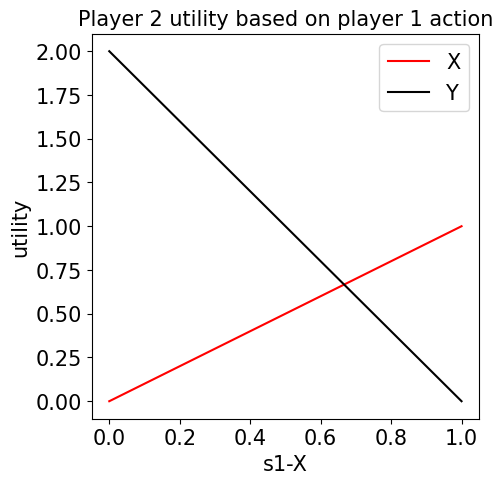

In [3]:
s1_X = np.linspace(0, 1, 100)
return_X2_given_s1 = 1*s1_X
return_Y2_given_s1 = 2*(1-s1_X)
plt.figure(figsize=(5,5))
plt.plot(s1_X,return_X2_given_s1,label="X",color="red")
plt.plot(s1_X,return_Y2_given_s1,label="Y",color="black")
plt.legend(fontsize=15)
plt.xlabel('s1-X',fontsize=15)
plt.ylabel('utility',fontsize=15)
plt.tick_params(labelsize=15)
plt.title("Player 2 utility based on player 1 action",fontsize=15)
plt.show()

It is easy to see that $X$ is a best response if $s_1^X>=\frac{2}{3}$. Likewise $Y$ is a best response if $s_1^X<=\frac{2}{3}$. We can then label the space of $s_1$ with these. So the final result is as follows:

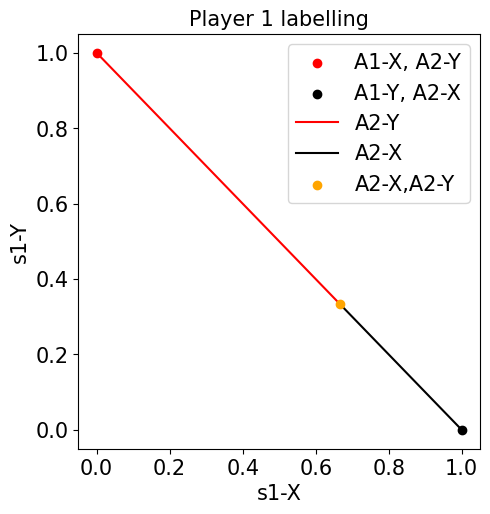

In [4]:
plt.figure(figsize=(5,5))
plt.scatter([0],[1],label="A1-X, A2-Y",color="red")
plt.scatter([1],[0],label="A1-Y, A2-X",color="black")
plt.plot(np.linspace(0,2/3,2),1-np.linspace(0,2/3,2),label="A2-Y",color="red")
plt.plot(np.linspace(2/3,1,2),1-np.linspace(2/3,1,2),label="A2-X",color="black")
plt.scatter([2/3],[1/3],label="A2-X,A2-Y",color="orange",zorder=10)
plt.legend(fontsize=15)
plt.xlabel('s1-X',fontsize=15)
plt.ylabel('s1-Y',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.title("Player 1 labelling",fontsize=15)
plt.show()

On the red line we have points where $Y$ is the best option for agent 2. The black line is where $X$ is the best option for 2. The red and black dots also include $X$ and $Y$ for player 1 respectively, as the probability is 0. Finally, the yellow dot includes both $X$ and $Y$ for player 2. 

As above we can also do the same graph as above for the benefit of both actions to $s_2$, given $s_1$:

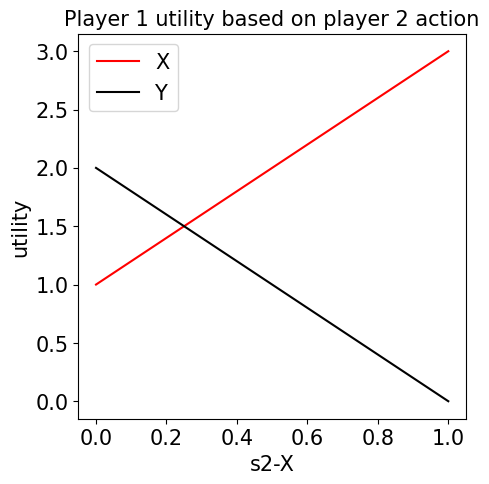

In [5]:
s2_X = np.linspace(0, 1, 100)
return_X1_given_s2 = 3*s2_X+1*(1-s2_X)
return_Y1_given_s2 = 2*(1-s2_X)
plt.figure(figsize=(5,5))
plt.plot(s2_X,return_X1_given_s2,label="X",color="red")
plt.plot(s2_X,return_Y1_given_s2,label="Y",color="black")
plt.legend(fontsize=15)
plt.xlabel('s2-X',fontsize=15)
plt.ylabel('utility',fontsize=15)
plt.tick_params(labelsize=15)
plt.title("Player 1 utility based on player 2 action",fontsize=15)
plt.show()

We see that $X$ is the best action if $s_2^X>\frac{1}{4}$, otherwise $Y$. This gives us the label plot:

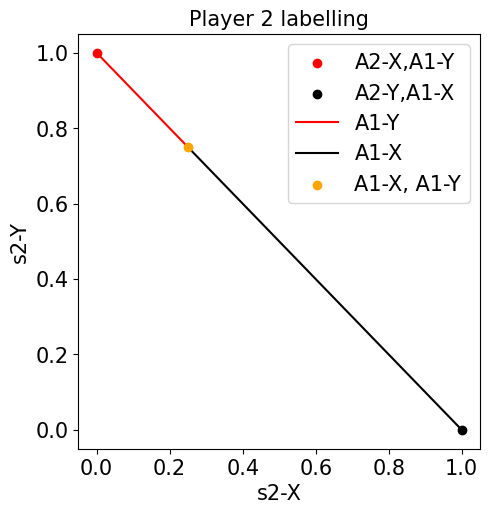

In [6]:
plt.figure(figsize=(5,5))
plt.scatter([0],[1],label="A2-X,A1-Y",color="red")
plt.scatter([1],[0],label="A2-Y,A1-X",color="black")
plt.plot(np.linspace(0,1/4,2),1-np.linspace(0,1/4,2),label="A1-Y",color="red")
plt.plot(np.linspace(1/4,1,2),1-np.linspace(1/4,1,2),label="A1-X",color="black")
plt.scatter([1/4],[3/4],label="A1-X, A1-Y",color="orange",zorder=10)
plt.legend(fontsize=15)
plt.xlabel('s2-X',fontsize=15)
plt.ylabel('s2-Y',fontsize=15)
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.title("Player 2 labelling",fontsize=15)
plt.show()

Finally, we can search for the combination of $s_1$ and $s_2$ which gives all labels:

In [7]:
s1_labels = {
    "red dot":["A1-X","A2-Y"],
    "black dot":["A1-Y","A2-X"],
    "red line":["A2-Y"],
    "black line":["A2-X"],
    "yellow dot":["A2-X","A2-Y"]
}
s2_labels = {
    "red dot":["A2-X","A1-Y"],
    "black dot":["A2-Y","A1-X"],
    "red line":["A1-Y"],
    "black line":["A1-X"],
    "yellow dot":["A1-X","A1-Y"]
}
for lab1 in s1_labels.keys():
    for lab2 in s2_labels.keys():
        union = s1_labels[lab1]+s2_labels[lab2]
        if("A1-X" in union and "A1-Y" in union and "A2-X" in union and "A2-Y" in union):
            print("s1:",lab1,"s2:",lab2,"is an equilibrium")

s1: red dot s2: red dot is an equilibrium
s1: black dot s2: black dot is an equilibrium
s1: yellow dot s2: yellow dot is an equilibrium


As we can see this gives all 3 equilibrium. There is the mixed strategy, as well as the two pure stategies which are clear from the values:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} \\
\hline
\text{X} & 3,1 & 1,0 \\
\text{Y} & 0,0 & 2,2 \\
\end{array}
$

In practice we don't want to calculate all the labels for all the points. There are a couple of tricks we can use however to make it more of a path-finding problem. The following notebook goes over this all in more detail.

#### 4.2.3 SEM

An alternative to the lemke-howson algorithm is called SEM (support-enumeration-method). It seems a pretty straightforward idea to just filter out the strategies of both players which are dominated first, and then enumerate the remaining strategies (from smallest support to largest). 

#### 4.2.4 Beyond sample equilibrium computation

We also might want to know other things about the equilibrium, such as whether it is unique, pareto optimal, etc. However, all these problems turn out to be computationally difficult. Everything seems exponential. 